In [1]:
%matplotlib inline
%load_ext Cython

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs 
from numba import jit, vectorize, float64, int64

In [3]:
sns.set_context('notebook', font_scale=1.5)

# Making Python faster

This homework provides practice in making Python code faster. Note that we start with functions that already use idiomatic `numpy` (which are about two orders of magnitude faster than the pure Python versions).

### Functions to optimize

In [4]:
def logistic(x):
    """Logistic function."""
    return np.exp(x)/(1 + np.exp(x))

def gd(X, y, beta, alpha, niter):
    """Gradient descent algorihtm."""
    n, p = X.shape
    Xt = X.T
    for i in range(niter):
        y_pred = logistic(X @ beta)
        epsilon = y - y_pred
        grad = Xt @ epsilon / n
        beta += alpha * grad
    return beta

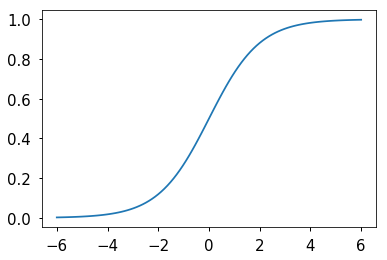

In [5]:
x = np.linspace(-6, 6, 100)
plt.plot(x, logistic(x))
pass

### Data set for classification

In [6]:
n = 10000
p = 2
X, y = make_blobs(n_samples=n, n_features=p, centers=2, cluster_std=1.05, random_state=23)
X = np.c_[np.ones(len(X)), X]
y = y.astype('float')

### Using gradient descent for classification by logistic regression

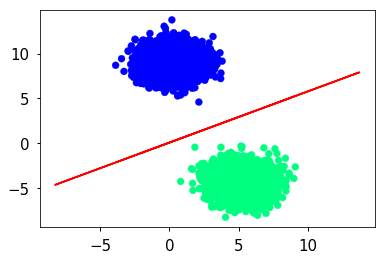

In [7]:
# initial parameters
niter = 1000
α = 0.01
β = np.zeros(p+1)

# call gradient descent
β = gd(X, y, β, α, niter)

# assign labels to points based on prediction
y_pred = logistic(X @ β)
labels = y_pred > 0.5

# calculate separating plane
sep = (-β[0] - β[1] * X)/β[2]

plt.scatter(X[:, 1], X[:, 2], c=labels, cmap='winter')
plt.plot(X, sep, 'r-')
pass

**1**. Rewrite the `logistic` function so it only makes one `np.exp` call. Compare the time of both versions with the input x given below using the `@timeit` magic. (10 points)

In [8]:
np.random.seed(123)
n = int(1e7)
x = np.random.normal(0, 1, n)

In [9]:
def logistic2(x):
    return 1/(1 + np.exp(-x))

In [10]:
%timeit logistic(x)
%timeit logistic2(x)

261 ms ± 16.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
170 ms ± 11.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**2**. (20 points) Use `numba` to compile the gradient descent function. 

- Use the `@vectorize` decorator to create a ufunc version of the logistic function and call this `logistic_numba_cpu` with function signatures of `float64(float64)`. Create another function called `logistic_numba_parallel` by giving an extra argument to the decorator of `target=parallel` (5 points)
- For each function, check that the answers are the same as with the original logistic function using  `np.testing.assert_array_almost_equal`. Use `%timeit` to compare the three logistic functions (5 points)
- Now use `@jit` to create a JIT_compiled version of the `logistic` and `gd` functions, calling them `logistic_numba` and `gd_numba`. Provide appropriate function signatures to the decorator in each case. (5 points)
- Compare the two gradient descent functions `gd` and `gd_numba` for correctness and performance. (5 points)

In [11]:
@vectorize([float64(float64)])
def logistic_numba_cpu(x):
    return 1/(1 + np.exp(-x))

@vectorize([float64(float64)], target='parallel')
def logistic_numba_parallel(x):
    return 1/(1 + np.exp(-x))

In [12]:
np.testing.assert_array_almost_equal(logistic(x), logistic2(x))
np.testing.assert_array_almost_equal(logistic_numba_cpu(x), logistic2(x))
np.testing.assert_array_almost_equal(logistic_numba_parallel(x), logistic2(x))

In [13]:
%timeit logistic2(x)
%timeit logistic_numba_cpu(x)
%timeit logistic_numba_parallel(x)

170 ms ± 8.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
103 ms ± 3.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
54.1 ms ± 2.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
@jit('double[:](double[:])')
def logistic_numba(x):
    """Logistic function."""
    n = x.shape[0]
    prob = np.zeros(n)
    for i in range(n):
        prob[i] = 1/(1+np.exp(-x[i]))
    return prob

@jit('double[:](double[:,:],double[:])')
def matrix_vec_mul_numba(M, vec):
    n, p = M.shape
    res = np.zeros(n)
    for i in range(n):
        for j in range(p):
            res[i] += M[i,j] * vec[j]
    return res


@jit('double[:](double[:,:],double[:],double[:],double,int32)')
def gd_numba(X, y, beta, alpha, niter):
    n, p = X.shape
    Xt = X.T
    for i in range(niter):
        y_pred = logistic_numba(matrix_vec_mul_numba(X, beta))
        epsilon = y - y_pred
        raw_grad = matrix_vec_mul_numba(Xt, epsilon)
        for j in range(p):
            beta[j] += alpha * raw_grad[j] / n
    return beta

In [15]:
np.testing.assert_array_almost_equal(gd(X, y, β, α, niter), gd_numba(X, y, β, α, niter))
%timeit gd(X, y, β, α, niter)
%timeit gd_numba(X, y, β, α, niter)

273 ms ± 9.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
173 ms ± 3.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**3**. (30 points) Use `cython` to compile the gradient descent function. 

- Cythonize the logistic function as `logistic_cython`. Use the `--annotate` argument to the `cython` magic function to find slow regions. Compare accuracy and performance. The final performance should be comparable to the `numba` cpu version. (10 points)
- Now cythonize the gd function as `gd_cython`. This function should use of the cythonized `logistic_cython` as a C function call.  Compare accuracy and performance. The final performance should be comparable to the `numba` cpu version. (20 points)

Hints: 

- Give static types to all variables
- Know how to use `def`, `cdef` and `cpdef`
- Use Typed MemoryViews
- Find out how to transpose a Typed MemoryView to store the transpose of X
- Typed MemoryVeiws are not `numpy` arrays - you often have to write explicit loops to operate on them
- Use the cython boundscheck, wraparound, and cdivision operators

In [16]:
%%cython -a

import cython
import numpy as np
cimport numpy as np
from libc.math cimport exp

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def logistic_cython(double[:] x):
    cdef int n
    cdef double[:] prob
    
    n = x.shape[0]
    prob = np.zeros(n)
    for i in range(n):
        prob[i] = 1/(1+exp(-x[i]))
    return prob

In [17]:
np.testing.assert_array_almost_equal(logistic2(x), logistic_cython(x)) 
%timeit logistic2(x)
%timeit logistic_numba(x)
%timeit logistic_numba_cpu(x)
%timeit logistic_cython(x)

174 ms ± 13.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
124 ms ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
109 ms ± 5.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
103 ms ± 4.77 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
%%cython -a

import cython
import numpy as np
cimport numpy as np
from libc.math cimport exp

@cython.cdivision(True)
cdef double logistic_cython(double x):
    return 1/(1+exp(-x))

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def gd_cython(double[:,:] X, double[:] y, double[:] beta, double alpha, int niter):
    cdef int n,p
    cdef double tmp
    cdef double[:,:] Xt
    cdef double[:] y_pred,epsilon,raw_grad
    
    n= X.shape[0]
    p = X.shape[1]
    Xt = np.zeros((p,n))
    y_pred = np.zeros(n)
    epsilon = np.zeros(n)
    raw_grad = np.zeros(p)
    for i in range(p):
        for j in range(n):
            Xt[i,j] = X[j,i]

    for i in range(niter):
        for j in range(n):
            tmp = 0
            for k in range(p):
                tmp += X[j,k] * beta[k]
            y_pred[j] = logistic_cython(tmp)
            epsilon[j] = y[j] - y_pred[j]
        for j in range(p):
            tmp = 0
            for k in range(n):
                tmp += Xt[j,k] * epsilon[k]
            beta[j] += alpha * tmp / n
    return beta

In [19]:
np.testing.assert_array_almost_equal(gd_numba(X, y, β, α, niter), gd_cython(X, y, β, α, niter))
%timeit gd_numba(X, y, β, α, niter)
%timeit gd_cython(X, y, β, α, niter)

173 ms ± 2.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
175 ms ± 20.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**4**. (40 points) Wrapping modules in C++.

Rewrite the `logistic` and `gd` functions in C++, using `pybind11` to create Python wrappers.  Compare accuracy and performance as usual. Replicate the plotted example using the C++ wrapped functions for `logistic` and `gd`

- Writing a vectorized `logistic` function callable from both C++ and Python (10 points)
- Writing the `gd` function callable from Python (25 points)
- Checking accuracy, benchmarking and creating diagnostic plots (5 points)

Hints:

- Use the C++ `Eigen` library to do vector and matrix operations (include path is `../notebooks/eigen3`)
- When calling the exponential function, you have to use `exp(m.array())` instead of `exp(m)` if you use an Eigen dynamic template.
- Use `cppimport` to simplify the wrapping for Python
- See [`pybind11` docs](http://pybind11.readthedocs.io/en/latest/index.html)
- See my [examples](http://people.duke.edu/~ccc14/cspy/18G_C++_Python_pybind11.html#) for help

In [20]:
%%file wrap1.cpp
<%
cfg['compiler_args'] = ['-std=c++11']
cfg['include_dirs'] = ['../notebooks/eigen3']
setup_pybind11(cfg)
%>

#include <pybind11/pybind11.h>
#include <pybind11/eigen.h>

Eigen::VectorXd logistic(Eigen::VectorXd x){
    return x.unaryExpr([](double x){return 1/(1+exp(-x));});
}

namespace py = pybind11;

PYBIND11_MODULE(wrap1, m) {
    m.doc() = "pybind11 example plugin";
    m.def("logistic", &logistic, "A vectroized logistic function.");
}

Overwriting wrap1.cpp


In [21]:
import cppimport
import numpy as np

code = cppimport.imp("wrap1")
logistic_new = code.logistic
x = np.linspace(-6, 6, 100)
np.testing.assert_array_almost_equal(logistic2(x), logistic_new(x))
%timeit logistic2(x)
%timeit logistic_cython(x)
%timeit logistic_new(x)

5.15 µs ± 549 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
4.32 µs ± 425 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
4.08 µs ± 266 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


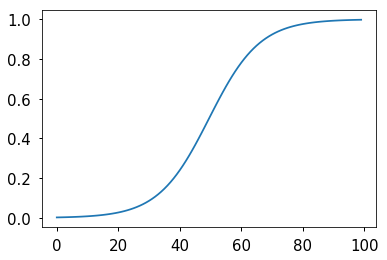

In [22]:
plt.plot(logistic_new(x))
pass

In [33]:
%%file wrap2.cpp
<%
cfg['compiler_args'] = ['-std=c++11']
cfg['include_dirs'] = ['../notebooks/eigen3']
setup_pybind11(cfg)
%>

#include <pybind11/pybind11.h>
#include <pybind11/eigen.h>

Eigen::VectorXd gd(Eigen::MatrixXd X, Eigen::VectorXd y, Eigen::VectorXd beta, double alpha, int niter){
    int n = X.rows();
    int p = X.cols();
    int tmp;
    Eigen::MatrixXd Xt = X.transpose();
    Eigen::VectorXd y_pred = Eigen::VectorXd::Zero(n);
    Eigen::VectorXd epsilon = Eigen::VectorXd::Zero(n);
    Eigen::VectorXd raw_grad = Eigen::VectorXd::Zero(p);

    for(int i=0; i<niter; i++){
        for(int j=0;j<n;j++){
            tmp = 0;
            for(int k=0;k<p;k++){
                tmp += X(j,k) * beta(k);
            }   
            y_pred(j) = 1/(1+std::exp(-tmp));
            epsilon(j) = y(j) - y_pred(j);
        } 
        for(int j=0;j<p;j++){
            tmp = 0;
            for(int k=0;k<n;k++){
                tmp += Xt(j,k) * epsilon(k);
            } 
            beta(j) += alpha * tmp / n;
        }     
    } 
    return beta;
}

namespace py = pybind11;

PYBIND11_MODULE(wrap2, m) {
    m.doc() = "pybind11 example plugin";
    m.def("gd", &gd, "Gradient Descent Function.");
}

Overwriting wrap2.cpp


In [34]:
import cppimport
import numpy as np

code = cppimport.imp("wrap2")
gd_new = code.gd
np.testing.assert_array_almost_equal(gd(X, y, β, α, niter), gd_new(X, y, β, α, niter))
%timeit gd(X, y, β, α, niter)
%timeit gd_cython(X, y, β, α, niter)
%timeit gd_new(X, y, β, α, niter)

262 ms ± 4.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
156 ms ± 941 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
301 ms ± 6.12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


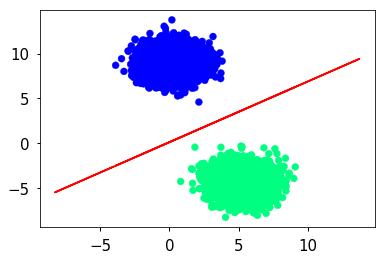

In [25]:
β = gd_new(X, y, β, α, niter)
# assign labels to points based on prediction
y_pred = logistic(X @ β)
labels = y_pred > 0.5

# calculate separating plane
sep = (-β[0] - β[1] * X)/β[2]

plt.scatter(X[:, 1], X[:, 2], c=labels, cmap='winter')
plt.plot(X, sep, 'r-')
pass